In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('./data.csv')

# EDA of raw_data : 'data.csv'

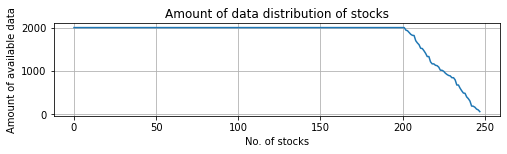

Number of available stocks:202
The number of missing value = 0


In [3]:
# Filtering out the stocks with inadequate data

tickcounts= data.ticker.value_counts()

plt.figure(figsize = (8,1.7))
plt.plot(tickcounts.values)
plt.ylabel('Amount of available data')
plt.xlabel('No. of stocks')
plt.title('Amount of data distribution of stocks')
plt.grid()
plt.show()

availstocks = list(tickcounts[:202].index)# Since the dataset is already small. We could confidently throw away some stocks.
print('Number of available stocks:%d'%len(availstocks))
print('='*40)

data = data[data['ticker'].isin(availstocks)]

# Check if there are missing values in the dataframe

print('The number of missing value = %d'%data.isnull().sum().sum())
print('='*40)


# Idea-generating for strategy


Since I only get price and vols, I should firstly generate some basic technical factors like moving average of prices and vols

- [ ] Let's consider the 'last' as the 'last tick'


In [4]:
_name = availstocks[0]
df = data[data['ticker']==_name]
df = df[['last','volume']]
df.index = np.arange(df.shape[0])

## Price factor

In [10]:
df['ma5'] = df['last'].rolling(window = 5).mean()
df['ma10'] = df['last'].rolling(window = 10).mean()
df['ma20'] = df['last'].rolling(window = 20).mean()

df['long_sig'] = (df['ma5']>df['ma10'])&(df['ma10']>df['ma20'])
df['short_sig'] = (df['ma5']<df['ma10'])&(df['ma10']<df['ma20'])
df.tail(4)

,last,volume,ma5,ma10,ma20,long_sig,short_sig
2001,2561.0,750400,2680.8,2683.2,2765.80,False,True
2002,2573.0,794100,2649.4,2669.0,2737.45,False,True
2003,2604.0,607500,2631.8,2663.4,2720.25,False,True
2004,2673.0,584300,2614.8,2668.7,2711.75,False,True


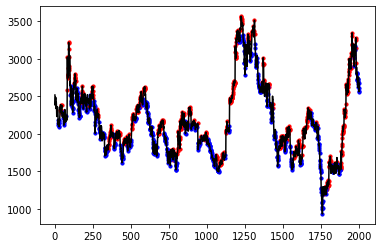

In [11]:
long_sig = list(df[df['long_sig']==1].index)
long_price = [df['last'].iloc[idx] for idx in long_sig]
short_sig = list(df[df['short_sig']==1].index)
short_price = [df['last'].iloc[idx] for idx in short_sig]

plt.scatter(long_sig, long_price,s = 10, color = 'r')
plt.scatter(short_sig, short_price,s = 10, color = 'blue')
plt.plot(df['last'].values,color = 'black')
plt.show()

In the graph above, we observe that the 
- [ ] red points appear when the stock rise.
- [ ] blue points appear when the stock drops.

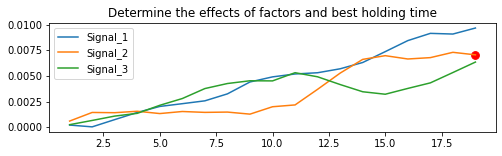

In [9]:
# Let's check if this factor is useful

# Dividing df into 3 part by long_sig, no_sig, short_sig

no_sig = list(df[(df['long_sig']==0) & (df['short_sig']==0)].index)
# Calculate the returns individually

    # indices = long_sig######
    # length = 15####
    
def calret(indices, length):
    newlist = [i for i in indices if (i<2005-length-1) ]
    new2list = [i+length for i in indices if (i<2005-length-1) ]
    df1 = df.loc[newlist]['last'].values
    df2 = df.loc[new2list]['last'].values
    ret = (df2-df1)/df1
    return ret

# Here we use the return mean as an indicator
hold_len = list(range(1,20))
hold_retlong = [calret(long_sig,t).mean() for t in hold_len]
hold_retno = [calret(no_sig,t).mean() for t in hold_len]
hold_retshort = [calret(short_sig,t).mean() for t in hold_len]

plt.figure(figsize= (8,2))
plt.title('Determine the effects of factors and best holding time')
plt.plot(hold_len, hold_retlong,label = 'Signal_1')
plt.plot(hold_len, hold_retno,label = 'Signal_2')
plt.plot(hold_len, hold_retshort,label = 'Signal_3')
plt.scatter(hold_len[-1], hold_retno[-1],s = 60, color= 'r')
plt.legend()
plt.show()

The reason I stopped searching is because the red dot above. I will explain it in further version : )

## volume factor

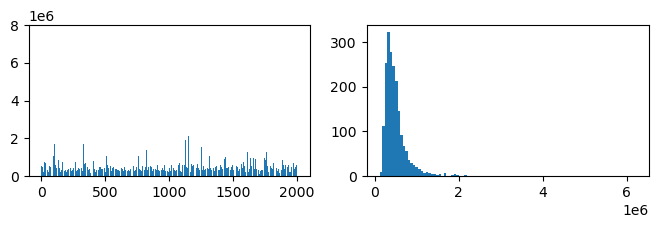

In [12]:
plt.figure(figsize =(8,2),dpi = 100)
plt.subplot(121)
plt.bar(range(len(df['volume'])), df['volume'])
plt.ylim(0,0.8e7)

plt.subplot(122)
plt.hist(df['volume'], bins = 100)

plt.show()

# df['volume'].describe()

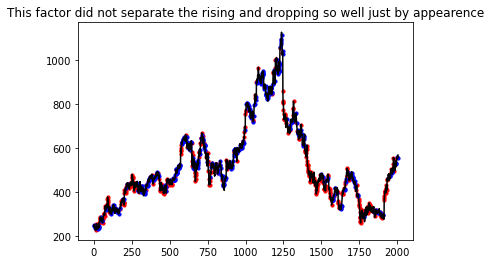

In [186]:
# volin_sig = df[]

from statsmodels.tsa.stattools import adfuller
adfuller(df['volume'])# Stationary
# Hence we could use the past dataset in future
import scipy.stats as stats
import statsmodels.api as sm


df['hi'] = (df['volume'] > df['volume'].describe()['75%'])
df['lo'] = (df['volume'] < df['volume'].describe()['25%'])

hi_sig = list(df[df['hi']==1].index)
lo_sig = list(df[df['lo']==1].index)

hi_price = [df['last'].iloc[idx] for idx in hi_sig]
lo_price = [df['last'].iloc[idx] for idx in lo_sig]

plt.scatter(hi_sig, hi_price,s = 10, color = 'r')
plt.scatter(lo_sig, lo_price,s = 10, color = 'blue')
plt.plot(df['last'].values,color = 'black')
plt.title('This factor did not separate the rising and dropping so well just by appearence')
plt.show()

I intended to directly show, not really clear.

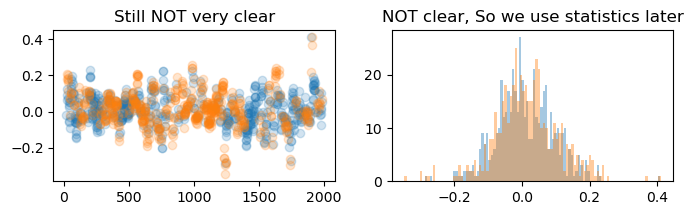

In [188]:
# 15days return 

tmpdf = df.copy()
tmpdf['15last'] = tmpdf['last'].shift(-15)
tmpdf['ret15'] = (tmpdf['15last']-tmpdf['last'])/tmpdf['last']

tmpdf = tmpdf.dropna()

hidf = tmpdf[tmpdf['hi']==1]
lodf = tmpdf[tmpdf['lo']==1]

plt.figure(figsize = (8,2),dpi = 100)
plt.subplot(121)
plt.title('Still NOT very clear')
plt.scatter(list(hidf.index),hidf['ret15'].values,alpha = 0.2)
plt.scatter(list(lodf.index),lodf['ret15'].values,alpha = 0.2)
plt.subplot(122)
plt.title('NOT clear, So we use statistics later')
plt.hist(hidf['ret15'].values,alpha = 0.4, bins = 100 )
plt.hist(lodf['ret15'].values,alpha = 0.4, bins = 100)
plt.show()

## Use t-stats to tell whether my volume factor could take effect

In [175]:
from scipy import stats 
print(stats.ttest_ind(hidf['ret15'].values,lodf['ret15'].values))
print('===========Hence, we cannot use these pair of factors, because p>0.05==========')

Ttest_indResult(statistic=-1.0943294732577258, pvalue=0.2740766809301102)
===========Hence, we cannot use these pair of factors, because p>0.05==========


In [184]:
print(stats.ttest_ind(hold_retlong, hold_retshort))
print(stats.ttest_ind(hold_retlong, hold_retno))
print('===========Hence,  Keep the factor, because p<0.1==========')

Ttest_indResult(statistic=3.8286724512489636, pvalue=0.0004954811015490555)
Ttest_indResult(statistic=2.0062038115433154, pvalue=0.0523925377251018)
===========Hence,  Keep the factor, because p<0.1==========


## The time left not too much, so I try a combination

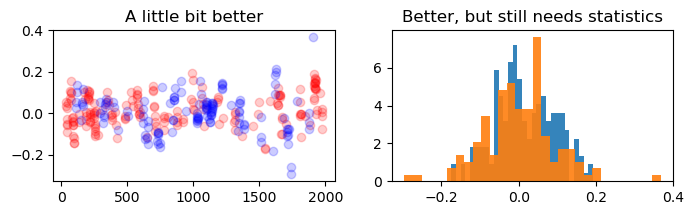

In [216]:
tmpdf = tmpdf.dropna()

longhi = list(tmpdf[(tmpdf['ma5']>tmpdf['ma10'])&(tmpdf['ma10']>tmpdf['ma20'])&(tmpdf['hi']==1)].index)
nolo = list(tmpdf[(tmpdf['ma5']<tmpdf['ma10'])&(tmpdf['ma10']<tmpdf['ma20'])&(tmpdf['lo']==1)].index)
longhiret = tmpdf[(tmpdf['ma5']>tmpdf['ma10'])&(tmpdf['ma10']>tmpdf['ma20'])&(tmpdf['hi']==1)]['ret15']
noloret = tmpdf[(tmpdf['ma5']<tmpdf['ma10'])&(tmpdf['ma10']<tmpdf['ma20'])&(tmpdf['lo']==1)]['ret15']

plt.figure(figsize = (8,2),dpi = 100)
plt.subplot(121)
plt.title('A little bit better')
plt.scatter(longhi,longhiret.values,alpha = 0.2, c = 'r')
plt.scatter(nolo,noloret.values,alpha = 0.2,c = 'b')
plt.subplot(122)
plt.title('Better, but still needs statistics')
plt.hist(longhiret.values,alpha = 0.9, bins = 30,density = True )
plt.hist(noloret.values,alpha = 0.9, bins = 30,density = True )
plt.show()

In [196]:
print(stats.ttest_ind(longhiret, noloret))
print('===========Hence,  Keep the factor, because p<0.1==========')
print('The combination works')

Ttest_indResult(statistic=-4.531104161898143, pvalue=8.386041356579832e-06)
===========Hence,  Keep the factor, because p<0.1==========
The combination works


# No.1 Stategy

| Item        |    Details   |   |   |   |   |   |
|----------------  |:-----------------------------------:|---|---|---|---|---|
| Targets        |    202 stocks in available stocks   |   |   |   |   |   |
| Buy points   | Signal_1,hi_1, position is not full |   |   |   |   |   |
| Holding length |        15 days                          |   |   |   |   |   |
| stop loss      | -10% for every deal                             |   |   |   |   |   |

In [13]:
class backtest1:
    def __init__(self,name,stoploss=0.1,holding_length=15):
        # Generating the price matrix
        
        tdf = data[data['ticker']==name].copy()
        tdf = tdf[['date','last','volume']]
        tdf.index = np.arange(tdf.shape[0])

        tdf['ma5'] = tdf['last'].rolling(window = 5).mean()
        tdf['ma10'] = tdf['last'].rolling(window = 10).mean()
        tdf['ma20'] = tdf['last'].rolling(window = 20).mean()
        tdf['long_sig'] = (tdf['ma5']>tdf['ma10'])&(tdf['ma10']>tdf['ma20'])
        tdf['short_sig'] = (tdf['ma5']<tdf['ma10'])&(tdf['ma10']<tdf['ma20'])
        
        self.hi = tdf['volume'].iloc[:1500].describe()['75%']
        self.lo = tdf['volume'].iloc[:1500].describe()['25%']
        tdf['hi'] = (tdf['volume']>self.hi)
        tdf['lo'] = (tdf['volume']<self.lo)
        
        tdf['15last'] = tdf['last'].shift(-holding_length)
        tdf['ret15'] = (tdf['15last']-tdf['last'])/tdf['last']
        self.tdf = tdf.iloc[1500:]
        self.stoploss = stoploss
        self.holding_length = holding_length
        
    def backtesting(self):
        self.pos = 0
        self.cap = 1
        self.earns = []
        
        net = [1]
        buyprices = []
        sellprices = []
        tdf = self.tdf
        nexttradeday = 0
        
        for idx in range(1, tdf.shape[0]):
            _lastclose, _close = tdf['last'].iloc[idx-1], tdf['last'].iloc[idx]
            lastnet = net[-1]
            # Calculation of net value:
            if self.pos:
                #print(idx, 'pos==1')##
                newnet = lastnet*(1+(_close-_lastclose)/_lastclose)
                #print(newnet)##
                net.append(newnet)
                # End of holding
                if (idx == selldate) | (idx == tdf.shape[0]-1): 
                    #print('Sell')##
                    self.pos = 0
                    sellprices.append(_close)
                continue
            
            # The signal of buyin
            if tdf['hi'].iloc[idx] and tdf['long_sig'].iloc[idx] and (idx<tdf.shape[0]-self.holding_length):
                #print(idx, 'Buy')##
                buyprices.append(_close)
                self.pos = 1
                selldate = idx + self.holding_length
            net.append(lastnet)
        self.net = net

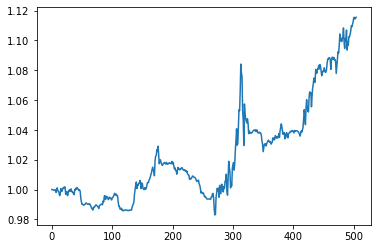

MaxDraw:0.054186
Annualized Revenue 5.619940
Sharpe: 1.654679184180638


In [14]:
ts = []
for i in range(202):
    test = backtest1(availstocks[i],holding_length = 10)
    test.backtesting()
    t = test.net
#     t= t[:480]
    ts.append(t)
    
ts = np.array(ts)

tsmean = ts.mean(axis = 0)
plt.plot(tsmean)
plt.show()

def MaxDrawdown(return_list):
    maxcum = np.zeros(len(return_list))
    b = return_list[0]
    for i in range(0,len((return_list))):
        if (return_list[i]>b):
            b = return_list[i]
        maxcum[i] = b
    i = np.argmax((maxcum-return_list)/maxcum) 
    if i == 0:
        return 0
    j = np.argmax(return_list[:i])   
    
    return (return_list[j]-return_list[i])/return_list[j]

print('MaxDraw:%f'%MaxDrawdown(tsmean))
print('Annualized Revenue %f'%((tsmean[-1]**0.5-1)*100))
print('Sharpe:',(tsmean[-1]**0.5-1.0)/np.std(tsmean))

# M

In [418]:
class backtest2:
    def __init__(self,name,stoploss=0.1,holding_length=15):
        # Generating the price matrix
        
        tdf = data[data['ticker']==name].copy()
        tdf = tdf[['date','last','volume']]
        tdf.index = np.arange(tdf.shape[0])

        tdf['ma5'] = tdf['last'].rolling(window = 5).mean()
        tdf['ma10'] = tdf['last'].rolling(window = 10).mean()
        tdf['ma20'] = tdf['last'].rolling(window = 20).mean()
        tdf['long_sig'] = (tdf['ma5']>tdf['ma10'])&(tdf['ma10']>tdf['ma20'])
        tdf['short_sig'] = (tdf['ma5']<tdf['ma10'])&(tdf['ma10']<tdf['ma20'])
        
        self.hi = tdf['volume'].iloc[:1500].describe()['75%']
        self.lo = tdf['volume'].iloc[:1500].describe()['25%']
        tdf['hi'] = (tdf['volume']>self.hi)
        tdf['lo'] = (tdf['volume']<self.lo)
        
        tdf['15last'] = tdf['last'].shift(-holding_length)
        tdf['ret15'] = (tdf['15last']-tdf['last'])/tdf['last']
        self.tdf = tdf.iloc[1500:]
        self.stoploss = stoploss
        self.holding_length = holding_length
        
    def backtesting(self):
        self.pos = 0
        self.cap = 1
        self.earns = []
        
        net = [1]
        buyprices = []
        sellprices = []
        tdf = self.tdf
        nexttradeday = 0
        
        for idx in range(1, tdf.shape[0]):
            _lastclose, _close = tdf['last'].iloc[idx-1], tdf['last'].iloc[idx]
            lastnet = net[-1]
            # Calculation of net value:
            if self.pos:
                #print(idx, 'pos==1')##
                newnet = lastnet*(1+(_close-_lastclose)/_lastclose)
                #print(newnet)##
                net.append(newnet)
                # End of holding
                if (idx == selldate) | (idx == tdf.shape[0]-1): 
                    #print('Sell')##
                    self.pos = 0
                    sellprices.append(_close)
                continue
            
            # The signal of buyin
            if tdf['long_sig'].iloc[idx] and (idx<tdf.shape[0]-self.holding_length):
                #print(idx, 'Buy')##
                buyprices.append(_close)
                self.pos = 1
                selldate = idx + self.holding_length
            net.append(lastnet)
        self.net = net

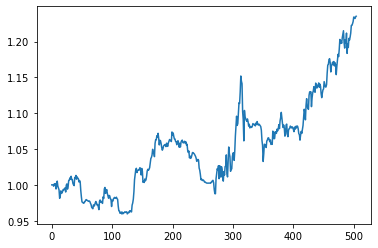

MaxDraw:0.103570
Annualized Revenue 11.148722
Sharpe: 1.703420662375712


In [421]:
ts = []
for i in range(202):
    test = backtest2(availstocks[i],holding_length = 10)
    test.backtesting()
    t = test.net
    ts.append(t)
    
ts = np.array(ts)

tsmean = ts.mean(axis = 0)
plt.plot(tsmean)
plt.show()

print('MaxDraw:%f'%MaxDrawdown(tsmean))
print('Annualized Revenue %f'%((tsmean[-1]**0.5-1)*100))
print('Sharpe:',(tsmean[-1]**0.5-1.0)/np.std(tsmean))

# Research: whether there are some-always losing stock in porfolio 2

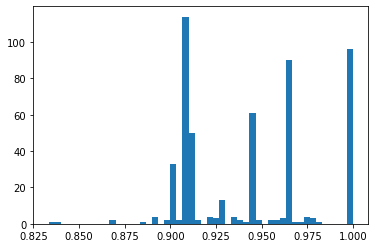

In [15]:
import math
plt.hist((ts[-1]),bins = 50)
plt.show()

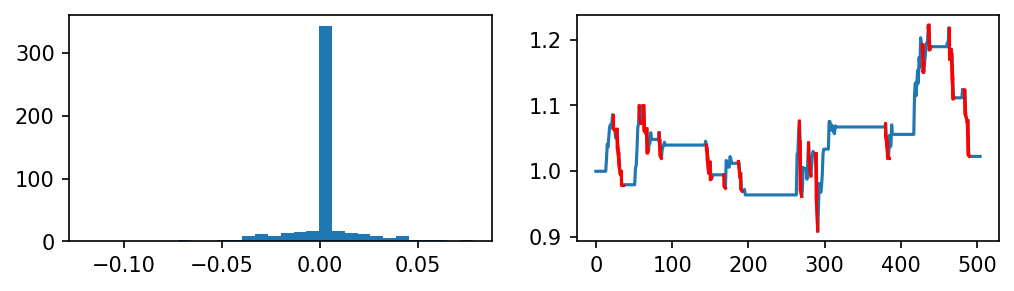

In [16]:
# def detect_fastdrop(ar):
#     x = np.array(ar)
#     xpre = x[:-2]
#     xpost = x[2:]
    
x = np.array(ts[5])
xpre = x[:-2]
xpost = x[2:]
plt.figure(figsize = (8,2),dpi = 150)
plt.subplot(121)
plt.hist(xpost-xpre,bins = 30)

reclist = []
tmpnetlist = []
for idx in range(505-2):
    if (xpost-xpre)[idx] <= -0.02:
        reclist.append([idx, idx, idx+2])
        tmpnetlist.append([x[idx],x[idx+1], x[idx+2]])
        
plt.subplot(122)
plt.plot(ts[5], zorder= 1)
for idx in range(len(reclist)):
    plt.plot(reclist[idx], tmpnetlist[idx], color = 'r')
plt.show()


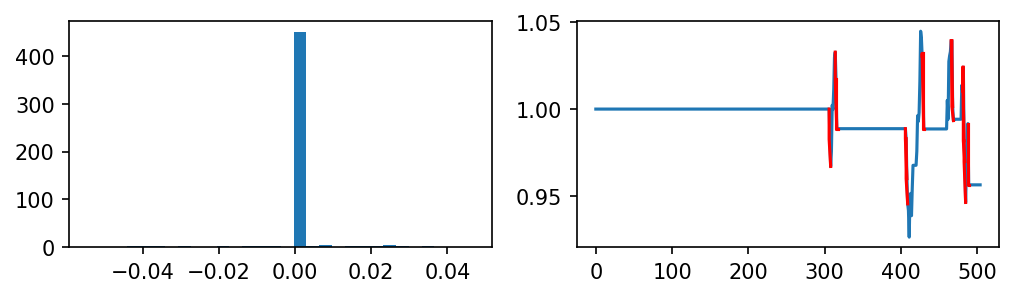

In [17]:
# def detect_fastdrop(ar):
#     x = np.array(ar)
#     xpre = x[:-2]
#     xpost = x[2:]
    
p = 4
x = np.array(ts[p])
xpre = x[:-2]
xpost = x[2:]
plt.figure(figsize = (8,2),dpi = 150)
plt.subplot(121)
plt.hist(xpost-xpre,bins = 30)

reclist = []
tmpnetlist = []
for idx in range(505-2):
    if (xpost-xpre)[idx] <= -0.02:
        reclist.append([idx, idx, idx+2])
        tmpnetlist.append([x[idx],x[idx+1], x[idx+2]])
        
plt.subplot(122)
plt.plot(ts[p], zorder= 1)
for idx in range(len(reclist)):
    plt.plot(reclist[idx], tmpnetlist[idx], color = 'r')
plt.show()


In [18]:
class backtest3:
    def __init__(self,name,stoploss=-0.04,holding_length=15):
        # Generating the price matrix
        
        tdf = data[data['ticker']==name].copy()
        tdf = tdf[['date','last','volume']]
        tdf.index = np.arange(tdf.shape[0])

        tdf['ma5'] = tdf['last'].rolling(window = 5).mean()
        tdf['ma10'] = tdf['last'].rolling(window = 10).mean()
        tdf['ma20'] = tdf['last'].rolling(window = 20).mean()
        tdf['long_sig'] = (tdf['ma5']>tdf['ma10'])&(tdf['ma10']>tdf['ma20'])
        tdf['short_sig'] = (tdf['ma5']<tdf['ma10'])&(tdf['ma10']<tdf['ma20'])
        
        self.hi = tdf['volume'].iloc[:1500].describe()['75%']
        self.lo = tdf['volume'].iloc[:1500].describe()['25%']
        tdf['hi'] = (tdf['volume']>self.hi)
        tdf['lo'] = (tdf['volume']<self.lo)
        
        tdf['15last'] = tdf['last'].shift(-holding_length)
        tdf['ret15'] = (tdf['15last']-tdf['last'])/tdf['last']
        self.tdf = tdf.iloc[1500:]
        self.stoploss = stoploss
        self.holding_length = holding_length
        
    def backtesting(self):
        self.pos = 0
        self.cap = 1
        self.earns = []
        
        net = [1]
        buyprices = []
        sellprices = []
        tdf = self.tdf
        nexttradeday = 0
        buyinnet = 1
        
        for idx in range(1, tdf.shape[0]):
            _lastclose, _close = tdf['last'].iloc[idx-1], tdf['last'].iloc[idx]
            lastnet = net[-1]
            # Calculation of net value:
            if self.pos:
                #print(idx, 'pos==1')##
                newnet = lastnet*(1+(_close-_lastclose)/_lastclose)
                #print(newnet)##
                net.append(newnet)
                # End of holding
                if (idx == selldate) | (idx == tdf.shape[0]-1): 
                    #print('Sell')##
                    self.pos = 0
                    sellprices.append(_close)
                if (net[-1] - net[-3])/net[-3]<self.stoploss:
                    print('Stoploss')
                    pos = 0
                    sellprices.append(_close)
                    nexttradeday = idx+3
                continue
            
            # The signal of buyin
            if tdf['long_sig'].iloc[idx] and (idx<tdf.shape[0]-self.holding_length) and (idx>nexttradeday):
                #print(idx, 'Buy')##
                buyprices.append(_close)
                self.pos = 1
                selldate = idx + self.holding_length
                buyinnet = lastnet
            net.append(lastnet)
            
        self.net = net

Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
S

Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
S

Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
Stoploss
S

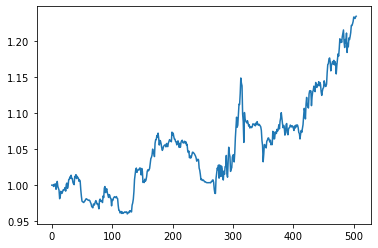

MaxDraw:0.101196
Annualized Revenue 11.098963
Sharpe: 1.7068134261604362


In [19]:
ts3 = []
for i in range(202):
    test = backtest3(availstocks[i],holding_length = 10)
    test.backtesting()
    t = test.net
    ts3.append(t)
    
ts3 = np.array(ts3)

tsmean3 = ts3.mean(axis = 0)
plt.plot(tsmean3)
plt.show()

print('MaxDraw:%f'%MaxDrawdown(tsmean3))
print('Annualized Revenue %f'%((tsmean3[-1]**0.5-1)*100))
print('Sharpe:',(tsmean3[-1]**0.5-1.0)/np.std(tsmean3))

In [464]:
pricemat = []
for _name in availstocks:
    tmpdata = data[data['ticker'] == _name]['last'].values
    pricemat.append(tmpdata)
pricemat = np.array(pricemat)


In [472]:
from tslearn.clustering import TimeSeriesKMeans
model = TimeSeriesKMeans(n_clusters=5, metric="dtw", max_iter=10)
# model.fit(pricemat[:,:2000])

MemoryError: Unable to allocate 30.5 MiB for an array with shape (2000, 2000) and data type float64

In [467]:
from tslearn.clustering import TimeSeriesKMeans
model = TimeSeriesKMeans(n_clusters=5, metric="dtw", max_iter=10)
model.fit(pricemat)


D:\Anaconda3\lib\site-packages\tslearn\clustering\kmeans.py:16: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  warnings.warn(


KeyboardInterrupt: 

# Further research: Try to look into the fails of in the first factor. 

# Other supporting materials that are not considered as main materials

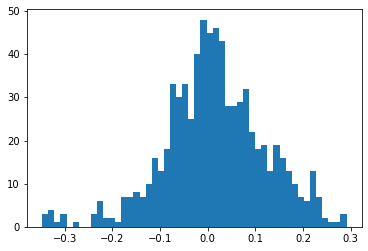

0.014159445419081963

In [111]:
plt.hist(ret,bins =50)
plt.show()
ret.mean()

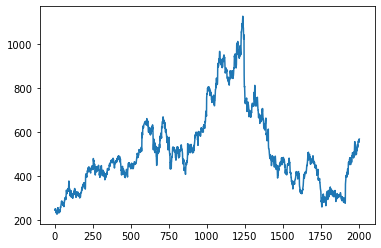

In [35]:
prices = data[data['ticker']==availstocks[0]]['last']
plt.plot(prices.values)